## Pre-requisites

- Required Python packages:
    - Pandas for dataframes
    - Numpy for number calculations
    - Matplotlib & Seaborn for plotting
    - TQDM for tracking loop progress
    - Time for time tracking
- Import the environment functions defined in Part 1 from the env.py file

In [1]:
# Default Imports
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure

import tqdm
import time

import warnings
warnings.filterwarnings("ignore")
from IPython.display import clear_output

# Figure Formatting
sns.set(rc={'figure.figsize':(15, 10)})
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 5})
sns.set_style("whitegrid", {'axes.grid' : False})

# Import environment from env.py
from env import action_outcome
from env import environment
#------------------------------------------------------------------------------------------


In [2]:
#------------------------------------------------------------------------------------------
states = ['A','B','C','D','E','F','G','T','M','recycling','trash']
rewards = [-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,1,-1]
x_list = [4,3,2,1,1,1,2,3,3,4,4]
y_list = [1,1,1,1,2,3,3,3,2,3,2]

# The low-level actions the agent can make in the environment
actions = ['left','right','up','down']
#------------------------------------------------------------------------------------------
# True probabilities, P, define the likelihood of each person following a command
# The probability of each other action (not the command given) are equally distributed from the result of (1-P)
# e.g. A has a 70% chance to follow their command 'LEFT' and a 30% chance to instead take equal choice of 'UP', 'RIGHT' or 'DOWN' (therefore is 10% chance each)
true_prob = [0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0, 0]
#------------------------------------------------------------------------------------------


In [225]:
for i in range(0,50):
    print("-------------------------------------------------")
    print(" ")
    print(environment(states, actions, rewards, x_list, y_list, 'C', 'right'))
    print(" ")

-------------------------------------------------
 
('C', 'right', 2, 1, 1, 0, 'B', 3, 1, -0.04)
 
-------------------------------------------------
 
('C', 'down', 2, 1, 0, 0, 'C', 2, 1, -0.04)
 
-------------------------------------------------
 
('C', 'right', 2, 1, 1, 0, 'B', 3, 1, -0.04)
 
-------------------------------------------------
 
('C', 'right', 2, 1, 1, 0, 'B', 3, 1, -0.04)
 
-------------------------------------------------
 
('C', 'right', 2, 1, 1, 0, 'B', 3, 1, -0.04)
 
-------------------------------------------------
 
('C', 'right', 2, 1, 1, 0, 'B', 3, 1, -0.04)
 
-------------------------------------------------
 
('C', 'right', 2, 1, 1, 0, 'B', 3, 1, -0.04)
 
-------------------------------------------------
 
('C', 'right', 2, 1, 1, 0, 'B', 3, 1, -0.04)
 
-------------------------------------------------
 
('C', 'right', 2, 1, 1, 0, 'B', 3, 1, -0.04)
 
-------------------------------------------------
 
('C', 'right', 2, 1, 1, 0, 'B', 3, 1, -0.04)
 
-----------

# Part 4 - Batch-Offline Learning

Assuming we don't have access to the underlying model but can sample trajectories that we can collect in batches to compute 'observed' probabilities instead.

Likewise, we can re-apply our policy iteration approach from Part 2 on these observed probabilities.

In [226]:
# Render data from observed episodes

num_episodes = 1

observed_episodes = pd.DataFrame()

index_tracker = 0
for episode in range(0,num_episodes):
    # Track episode number with simple print function
    clear_output(wait=True)
    print("Episodes Completed: ", np.round( (episode/num_episodes)*100,2),"%")

    # Random Start State
    state = random.choice(states)

    # Initialise action loop    
    a = 1
    while True:
        # End loop at terminal states
        if (state == 'recycling')|(state == 'trash'):
            break
        else:
    
            # Randomly select
            action = random.choice(actions)
            
            #------
            # Environment probabilistric outcome
            #---
            # environment fn output: return(state, action, state_x, state_y, u, v, next_state, next_state_x, next_state_y, reward)
            outcome = environment(states, actions, rewards, x_list, y_list, state, action)
            
            new_state = outcome[6]
            r = outcome[9]
            #------
            # Track outcomes
            observed_episodes = observed_episodes.append(pd.DataFrame({'episode':episode, 'action_num':a, 'state':state, 'action':action, 'next_state': new_state}, index = [index_tracker]))

            index_tracker = index_tracker+1

            # Move to next action, make the new state the current state
            #------
            a=a+1
            state=new_state
            #------



Episodes Completed:  0.0 %


In [227]:
observed_episodes

,episode,action_num,state,action,next_state
0,0,1,E,right,E
1,0,2,E,right,F
2,0,3,F,down,F
3,0,4,F,right,G
4,0,5,G,right,T
5,0,6,T,up,T
6,0,7,T,down,M
7,0,8,M,left,M
8,0,9,M,up,T
9,0,10,T,down,M


In [228]:
s_a_ns_count = observed_episodes.groupby(['state','action','next_state']).count().reset_index(drop=False)[['state','action','next_state','action_num']]
s_a_ns_count.columns = ['state','action','next_state','s_a_ns_counter']
s_a_ns_count

,state,action,next_state,s_a_ns_counter
0,E,right,E,1
1,E,right,F,1
2,F,down,F,1
3,F,right,G,1
4,G,right,T,1
5,M,left,M,3
6,M,left,trash,1
7,M,up,T,1
8,T,down,M,2
9,T,up,T,1


In [229]:
s_a_count = s_a_ns_count.groupby(['state','action']).sum().reset_index(drop=False)[['state','action','s_a_ns_counter']]
s_a_count.columns = ['state','action','s_a_counter']
s_a_count

,state,action,s_a_counter
0,E,right,2
1,F,down,1
2,F,right,1
3,G,right,1
4,M,left,4
5,M,up,1
6,T,down,2
7,T,up,1


In [230]:
transition_probs = s_a_ns_count.merge(s_a_count, how='left', on=['state','action'])[['state','action','next_state','s_a_counter','s_a_ns_counter']]
transition_probs['Prob'] = transition_probs['s_a_ns_counter']/transition_probs['s_a_counter']
transition_probs

,state,action,next_state,s_a_counter,s_a_ns_counter,Prob
0,E,right,E,2,1,0.50
1,E,right,F,2,1,0.50
2,F,down,F,1,1,1.00
3,F,right,G,1,1,1.00
4,G,right,T,1,1,1.00
5,M,left,M,4,3,0.75
6,M,left,trash,4,1,0.25
7,M,up,T,1,1,1.00
8,T,down,M,2,2,1.00
9,T,up,T,1,1,1.00


In [231]:
true_next_state_l = []
for n,row in transition_probs.iterrows():
    state = row['state']
    action = row['action']
    next_state = row['next_state']

    # Current state [x,y] coordinate
    state_x = x_list[states.index(state)]
    state_y = y_list[states.index(state)]
    # [x,y] direction of movement given current state and probabilistic action outcome
    u = action_outcome(state_x,state_y,action)[0]
    v = action_outcome(state_x,state_y,action)[1]
    # Next state [x,y]
    next_state_x = state_x + u
    next_state_y = state_y + v
    
    # Returns index of x + y position to then find the state name
    next_state = states[' '.join(str(x_list[i])+ "_" + str(y_list[i]) for i in range(0,len(x_list))).split().index(str(next_state_x) + "_" + str(next_state_y))]
    true_next_state_l.append(next_state)
transition_probs['true_n_s'] = true_next_state_l
transition_probs['True_Prob'] = np.where(transition_probs['state']=='T',1, np.where(transition_probs['true_n_s']==transition_probs['next_state'],0.7,0.1))
transition_probs['Prob_diff'] = (transition_probs['True_Prob'] - transition_probs['Prob'])
transition_probs['Prob_diff'] = transition_probs['Prob_diff'].abs()


In [232]:
transition_probs

,state,action,next_state,s_a_counter,s_a_ns_counter,Prob,true_n_s,True_Prob,Prob_diff
0,E,right,E,2,1,0.50,E,0.7,0.20
1,E,right,F,2,1,0.50,E,0.1,0.40
2,F,down,F,1,1,1.00,E,0.1,0.90
3,F,right,G,1,1,1.00,G,0.7,0.30
4,G,right,T,1,1,1.00,T,0.7,0.30
5,M,left,M,4,3,0.75,M,0.7,0.05
6,M,left,trash,4,1,0.25,M,0.1,0.15
7,M,up,T,1,1,1.00,T,0.7,0.30
8,T,down,M,2,2,1.00,M,1.0,0.00
9,T,up,T,1,1,1.00,T,1.0,0.00


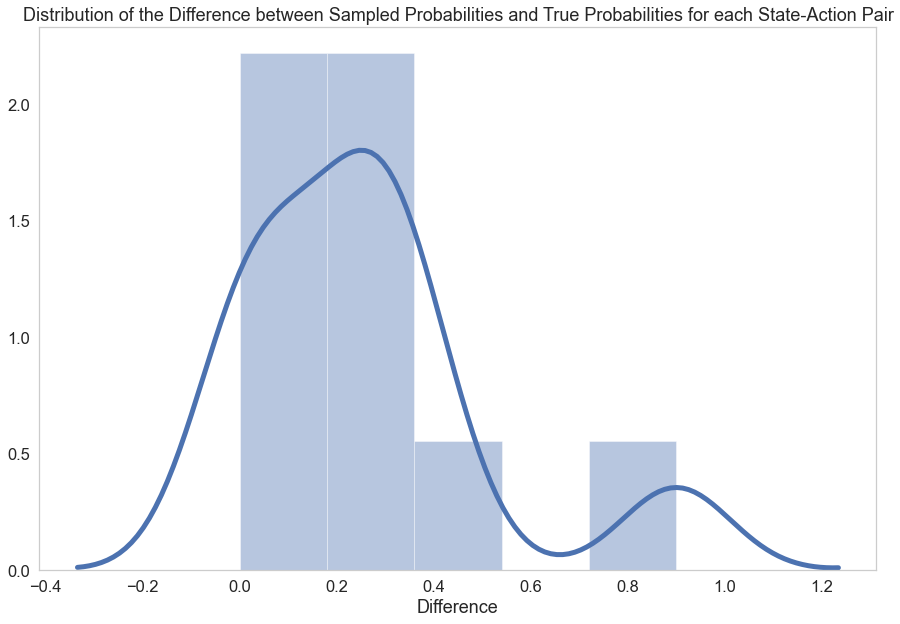

In [233]:
sns.distplot(transition_probs['Prob_diff'])
plt.title("Distribution of the Difference between Sampled Probabilities and True Probabilities for each State-Action Pair")
plt.xlabel("Difference")
plt.show()

Episodes Completed:  99.98 %


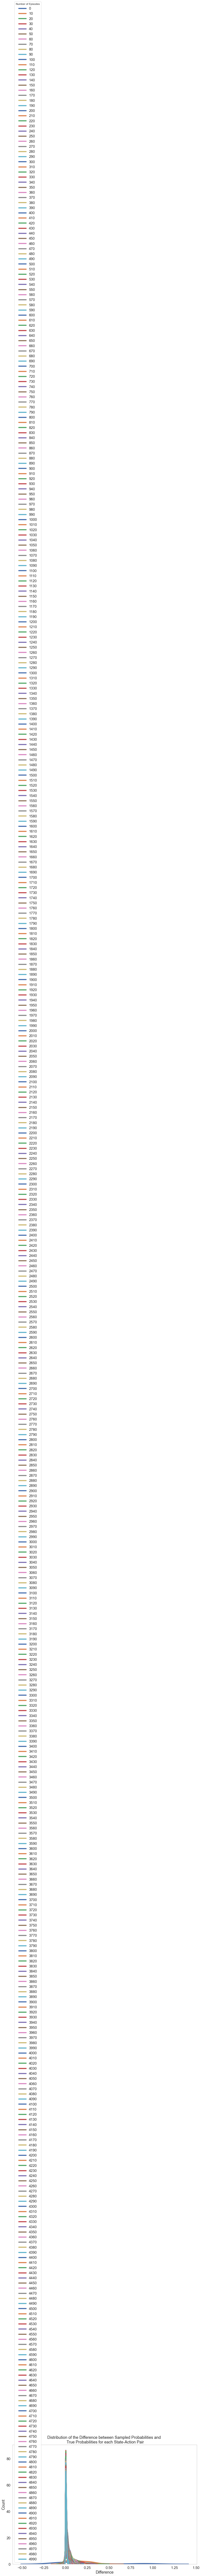

In [244]:
# Render data from observed episodes

num_episodes = 5000


observed_episodes = pd.DataFrame()
prob_comparison = pd.DataFrame()

index_tracker = 0
for episode in range(0,num_episodes):
    # Track episode number with simple print function
    clear_output(wait=True)
    print("Episodes Completed: ", np.round( (episode/num_episodes)*100,2),"%")

    # Random Start State
    state = random.choice(states)

    # Initialise action loop    
    a = 1
    while True:
        # End loop at terminal states
        if (state == 'recycling')|(state == 'trash'):
            break
        else:
    
            # Randomly select
            action = random.choice(actions)
            
            #------
            # Environment probabilistric outcome
            #---
            # environment fn output: return(state, action, state_x, state_y, u, v, next_state, next_state_x, next_state_y, reward)
            outcome = environment(states, actions, rewards, x_list, y_list, state, action)
            
            new_state = outcome[6]
            r = outcome[9]
            #------
            # Track outcomes
            observed_episodes = observed_episodes.append(pd.DataFrame({'episode':episode, 'action_num':a, 'state':state, 'action':action, 'next_state': new_state}, index = [index_tracker]))

            index_tracker = index_tracker+1

            # Move to next action, make the new state the current state
            #------
            a=a+1
            state=new_state
            #------

    # Compute Transition Probabilities and Compare to True Values
    s_a_ns_count = observed_episodes.groupby(['state','action','next_state']).count().reset_index(drop=False)[['state','action','next_state','action_num']]
    s_a_ns_count.columns = ['state','action','next_state','s_a_ns_counter']
    s_a_count = s_a_ns_count.groupby(['state','action']).sum().reset_index(drop=False)[['state','action','s_a_ns_counter']]
    s_a_count.columns = ['state','action','s_a_counter']
    transition_probs = s_a_ns_count.merge(s_a_count, how='left', on=['state','action'])[['state','action','next_state','s_a_counter','s_a_ns_counter']]
    transition_probs['Prob'] = transition_probs['s_a_ns_counter']/transition_probs['s_a_counter']

    true_next_state_l = []
    for n,row in transition_probs.iterrows():
        state = row['state']
        action = row['action']
        next_state = row['next_state']

        # Current state [x,y] coordinate
        state_x = x_list[states.index(state)]
        state_y = y_list[states.index(state)]
        # [x,y] direction of movement given current state and probabilistic action outcome
        u = action_outcome(state_x,state_y,action)[0]
        v = action_outcome(state_x,state_y,action)[1]
        # Next state [x,y]
        next_state_x = state_x + u
        next_state_y = state_y + v
        
        # Returns index of x + y position to then find the state name
        next_state = states[' '.join(str(x_list[i])+ "_" + str(y_list[i]) for i in range(0,len(x_list))).split().index(str(next_state_x) + "_" + str(next_state_y))]
        true_next_state_l.append(next_state)
    transition_probs['true_n_s'] = true_next_state_l
    transition_probs['True_Prob'] = np.where(transition_probs['state']=='T',1, 
                                    # Walls add 0.1 prob to reaching same state
                                    np.where((transition_probs['true_n_s']==transition_probs['next_state'])&((transition_probs['state']=='A')&((transition_probs['action']=='right') | (transition_probs['action']=='down'))),0.8,
                                    np.where((transition_probs['true_n_s']==transition_probs['next_state'])&((transition_probs['state']=='C')&((transition_probs['action']=='down') | (transition_probs['action']=='up'))),0.8,
                                    np.where((transition_probs['true_n_s']==transition_probs['next_state'])&((transition_probs['state']=='D')&((transition_probs['action']=='left') | (transition_probs['action']=='down'))),0.8,
                                    np.where((transition_probs['true_n_s']==transition_probs['next_state'])&((transition_probs['state']=='E')&((transition_probs['action']=='left') | (transition_probs['action']=='right'))),0.8,
                                    np.where((transition_probs['true_n_s']==transition_probs['next_state'])&((transition_probs['state']=='F')&((transition_probs['action']=='left') | (transition_probs['action']=='up'))),0.8,
                                    np.where((transition_probs['true_n_s']==transition_probs['next_state'])& ((transition_probs['state']=='G')&((transition_probs['action']=='up') | (transition_probs['action']=='down'))),0.8,

                                    np.where((transition_probs['state']==transition_probs['next_state'])&(transition_probs['state']=='A')&(transition_probs['action']=='up'),0.2,
                                    np.where((transition_probs['state']==transition_probs['next_state'])&(transition_probs['state']=='A')&(transition_probs['action']=='left'),0.2,
                                    np.where((transition_probs['state']==transition_probs['next_state'])&(transition_probs['state']=='C')&(transition_probs['action']=='left'),0.2,
                                    np.where((transition_probs['state']==transition_probs['next_state'])&(transition_probs['state']=='C')&(transition_probs['action']=='right'),0.2,
                                    np.where((transition_probs['state']==transition_probs['next_state'])&(transition_probs['state']=='D')&(transition_probs['action']=='up'),0.2,
                                    np.where((transition_probs['state']==transition_probs['next_state'])&(transition_probs['state']=='D')&(transition_probs['action']=='right'),0.2,
                                    np.where((transition_probs['state']==transition_probs['next_state'])&(transition_probs['state']=='E')&(transition_probs['action']=='up'),0.2,
                                    np.where((transition_probs['state']==transition_probs['next_state'])&(transition_probs['state']=='E')&(transition_probs['action']=='down'),0.2,
                                    np.where((transition_probs['state']==transition_probs['next_state'])&(transition_probs['state']=='F')&(transition_probs['action']=='right'),0.2,
                                    np.where((transition_probs['state']==transition_probs['next_state'])&(transition_probs['state']=='F')&(transition_probs['action']=='down'),0.2,
                                    np.where((transition_probs['state']==transition_probs['next_state'])&(transition_probs['state']=='G')&(transition_probs['action']=='left'),0.2,
                                    np.where((transition_probs['state']==transition_probs['next_state'])&(transition_probs['state']=='G')&(transition_probs['action']=='right'),0.2,

                                    np.where(transition_probs['true_n_s']==transition_probs['next_state'],0.7,0.1))))))))))))))))))))

    transition_probs['Prob_diff'] = (transition_probs['True_Prob'] - transition_probs['Prob'])
    transition_probs['Prob_diff'] = transition_probs['Prob_diff'].abs()


    prob_diff_mean = np.mean(transition_probs['Prob_diff'])
    prob_diff_std = np.std(transition_probs['Prob_diff'])
    prob_comparison = prob_comparison.append(pd.DataFrame({'episode':episode, 'prob_diff_mean':prob_diff_mean, 'prob_diff_std':prob_diff_std}, index=[episode]))

    if (episode % 10)==0:
        sns.distplot(transition_probs['Prob_diff'], hist=False, label = str(episode))
        plt.legend(title="Number of Episodes")
    else:
        continue
plt.title("Distribution of the Difference between Sampled Probabilities and \n True Probabilities for each State-Action Pair")
plt.xlabel("Difference")
plt.ylabel("Count")
plt.show()

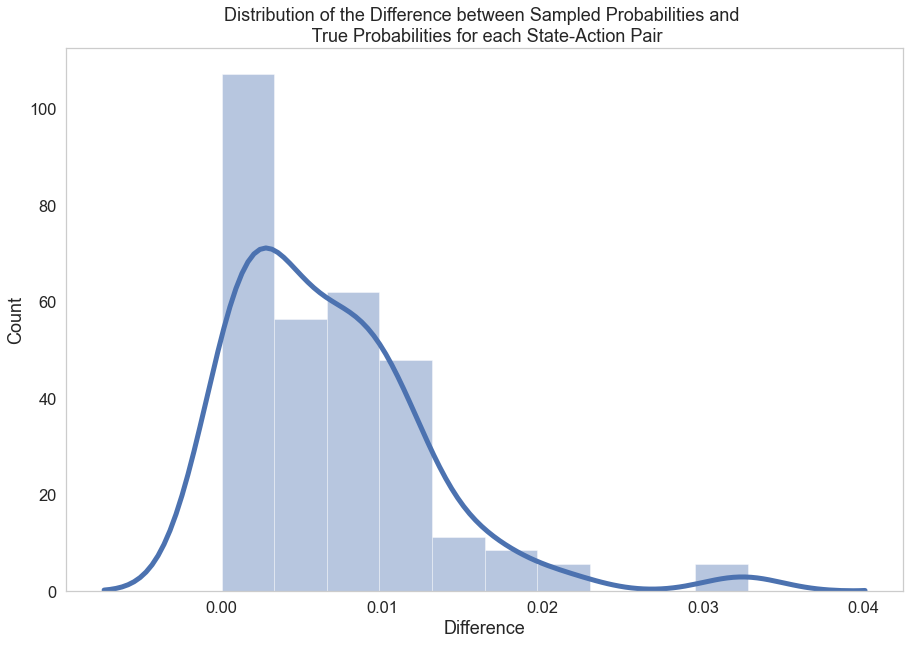

In [245]:
sns.distplot(transition_probs['Prob_diff'])
plt.title("Distribution of the Difference between Sampled Probabilities and \n True Probabilities for each State-Action Pair")
plt.xlabel("Difference")
plt.ylabel("Count")
plt.show()

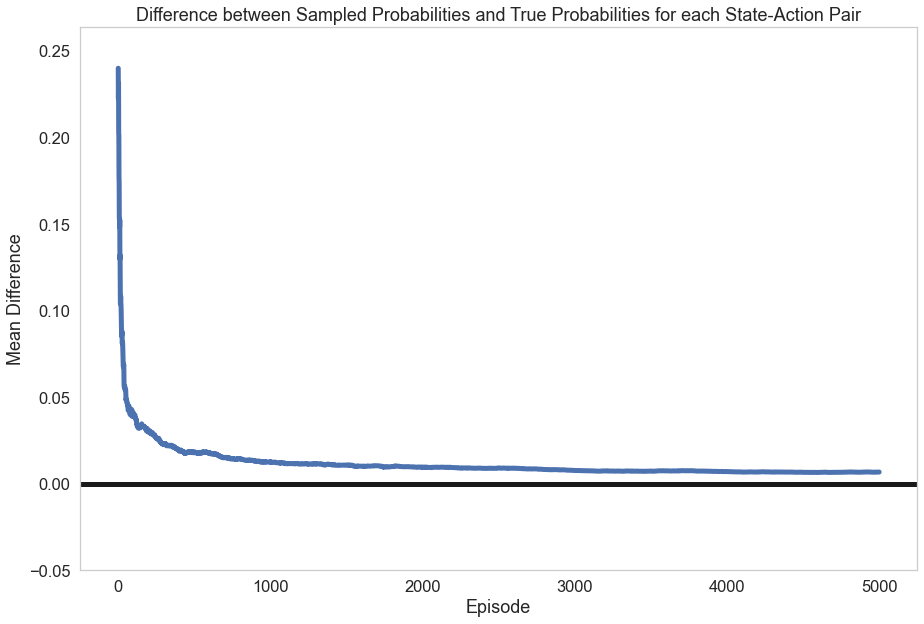

In [246]:
plt.plot(prob_comparison['episode'], prob_comparison['prob_diff_mean'])
plt.axhline(color='k')
plt.ylim(-0.05, max(prob_comparison['prob_diff_mean'])*1.1)

plt.title("Difference between Sampled Probabilities and True Probabilities for each State-Action Pair")
plt.ylabel("Mean Difference")
plt.xlabel("Episode")
plt.show()

# Applying Policy Iteration

Interval:  49
Episodes Completed:  99.0 %
Repeats Completed:  0.0 %
Repeats Completed:  4.0 %
Repeats Completed:  8.0 %
Repeats Completed:  12.0 %
Repeats Completed:  16.0 %
Repeats Completed:  20.0 %
Repeats Completed:  24.0 %
Repeats Completed:  28.0 %
Repeats Completed:  32.0 %
Repeats Completed:  36.0 %
Repeats Completed:  40.0 %
Repeats Completed:  44.0 %
Repeats Completed:  48.0 %
Repeats Completed:  52.0 %
Repeats Completed:  56.0 %
Repeats Completed:  60.0 %
Repeats Completed:  64.0 %
Repeats Completed:  68.0 %
Repeats Completed:  72.0 %
Repeats Completed:  76.0 %
Repeats Completed:  80.0 %
Repeats Completed:  84.0 %
Repeats Completed:  88.0 %
Repeats Completed:  92.0 %
Repeats Completed:  96.0 %
total time taken this loop:  2.2  seconds


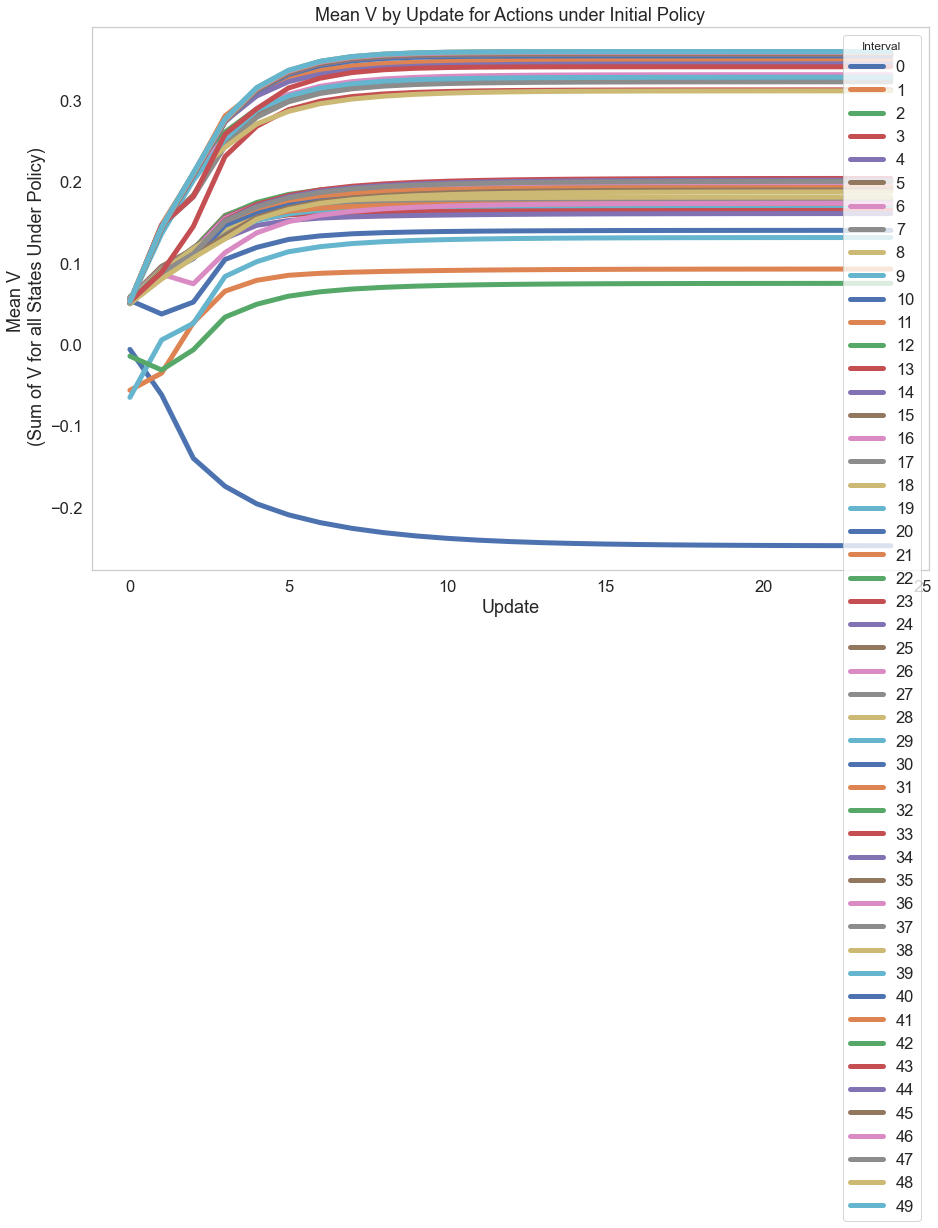

In [95]:
#------------------------------------------------------------------------------------------
states = ['A','B','C','D','E','F','G','T','M','recycling','trash']
x_list = [4,3,2,1,1,1,2,3,3,4,4]
y_list = [1,1,1,1,2,3,3,3,2,3,2]

# The low-level actions the agent can make in the environment
actions = ['left','right','up','down']
rewards = [-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,1,-1]

#initial_policy = ['left','up','right','up','up','right','right','right','up','up','up'] 
initial_policy = ['left','up','right','down','down','down','left','right','right','up','up'] 
#------------------------------------------------------------------------------------------

# Render data from observed episodes
num_episodes = 100
num_intervals = 50
action_cap = 50
#PI parameters
gamma = 0.8
num_repeats = 25
epsilon = 0.1

observed_episodes = pd.DataFrame()
interval_value_tracker = pd.DataFrame()

index_tracker = 0
overall_episode = 0
reward_tracking = pd.DataFrame()
for interval in range(0,num_intervals):
    if interval==0:
        policy = initial_policy
    else:
        policy = policy

    # Observe data for this policy
    prob_comparison = pd.DataFrame()
    for episode in range(0,num_episodes):
        overall_episode = overall_episode+1
        # Track episode number with simple print function
        clear_output(wait=True)
        print("Interval: ", interval)
        print("Episodes Completed: ", np.round( (episode/num_episodes)*100,2),"%")

        # Random Start State
        state = random.choice(states)

        # Initialise action loop    
        a = 1
        r_l = []
        while True:
            # End loop at terminal states
            if (state == 'recycling')|(state == 'trash'):
                break
            elif (a==action_cap):
                break
            else:
        
                # Randomly select
                action = policy[states.index(state)]
                
                #------
                # Environment probabilistric outcome
                #------
                # environment fn output: return(state, action, state_x, state_y, u, v, next_state, next_state_x, next_state_y, reward)
                outcome = environment(states, actions, rewards, x_list, y_list, state, action)
                new_state = outcome[6]
                r = outcome[9]
                gam = gamma**(a-1)
                r_l.append(r*gam)
                #------
                # Track outcomes
                observed_episodes = observed_episodes.append(pd.DataFrame({'episode':episode, 'action_num':a, 'state':state, 'action':action, 'next_state': new_state}, index = [index_tracker]))

                index_tracker = index_tracker+1

                # Move to next action, make the new state the current state
                #------
                a=a+1
                state=new_state
                #------
        reward_tracking = reward_tracking.append(pd.DataFrame({'interval':interval,'episode':episode,'overall_episode':overall_episode,'sum_R':np.sum(r_l)},index=[0]))

        # Compute Transition Probabilities and Compare to True Values
        s_a_ns_count = observed_episodes.groupby(['state','action','next_state']).count().reset_index(drop=False)[['state','action','next_state','action_num']]
        s_a_ns_count.columns = ['state','action','next_state','s_a_ns_counter']
        s_a_count = s_a_ns_count.groupby(['state','action']).sum().reset_index(drop=False)[['state','action','s_a_ns_counter']]
        s_a_count.columns = ['state','action','s_a_counter']
        transition_probs = s_a_ns_count.merge(s_a_count, how='left', on=['state','action'])[['state','action','next_state','s_a_counter','s_a_ns_counter']]
        transition_probs['Prob'] = transition_probs['s_a_ns_counter']/transition_probs['s_a_counter']

        true_next_state_l = []
        for n,row in transition_probs.iterrows():
            state = row['state']
            action = row['action']
            next_state = row['next_state']

            # Current state [x,y] coordinate
            state_x = x_list[states.index(state)]
            state_y = y_list[states.index(state)]
            # [x,y] direction of movement given current state and probabilistic action outcome
            u = action_outcome(state_x,state_y,action)[0]
            v = action_outcome(state_x,state_y,action)[1]
            # Next state [x,y]
            next_state_x = state_x + u
            next_state_y = state_y + v
            
            # Returns index of x + y position to then find the state name
            next_state = states[' '.join(str(x_list[i])+ "_" + str(y_list[i]) for i in range(0,len(x_list))).split().index(str(next_state_x) + "_" + str(next_state_y))]
            true_next_state_l.append(next_state)
        transition_probs['true_n_s'] = true_next_state_l
        transition_probs['True_Prob'] = np.where(transition_probs['state']=='T',1, np.where(transition_probs['true_n_s']==transition_probs['next_state'],0.7,0.1))
        transition_probs['Prob_diff'] = (transition_probs['True_Prob'] - transition_probs['Prob'])
        transition_probs['Prob_diff'] = transition_probs['Prob_diff'].abs()


        prob_diff_mean = np.mean(transition_probs['Prob_diff'])
        prob_diff_std = np.std(transition_probs['Prob_diff'])
        prob_comparison = prob_comparison.append(pd.DataFrame({'episode':episode, 'prob_diff_mean':prob_diff_mean, 'prob_diff_std':prob_diff_std}, index=[episode]))

    #------------------------------------------------------------------------------------------
    # Known probabilities, P, define the likelihood of each person following a command
    # The probability of each other action (not the command given) are equally distributed from the result of (1-P)
    # e.g. A has a 70% chance to follow their command 'LEFT' and a 30% chance to instead take equal choice of 'UP', 'RIGHT' or 'DOWN' (therefore is 10% chance each)
    #known_prob = [0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0, 0]
    #------------------------------------------------------------------------------------------

    # Our observed probs often have two directions that end up in same state due to walls so format doesn't match 0.7 but outcomes are the same

    #------------------------------------------------------------------------------------------
    # Apply Policy Iteration from "Part 2 - Model Based Policy Iteration.ipynb"

    value_table_init = pd.DataFrame()
    for n1,state in enumerate(states):
        policy_a = policy[n1]
        action_list = pd.DataFrame()
        for a1,action in enumerate(actions):
            state_x = x_list[n1]
            state_y = y_list[n1]
            for s2,state_2 in enumerate(states):
                try:
                    p = transition_probs[(transition_probs['state']==state)&(transition_probs['action']==action)&(transition_probs['next_state']==state_2)]['Prob'].iloc[0]
                except:
                    p = transition_probs[(transition_probs['state']==state)&(transition_probs['action']==action)&(transition_probs['next_state']==state_2)]['Prob']
                action_list  = action_list.append(pd.DataFrame({'state':state,'x':x_list[n1],'y':y_list[n1], 'action':action, 'next_state':state_2, 'prob':p}, index=[0]))
        value_table_init = value_table_init.append(action_list)
    value_table_init = value_table_init.reset_index(drop=True)


    u_l = []
    v_l = []
    next_state_l = []
    reward_l = []
    for n,row in value_table_init.iterrows():
        state = row['state']
        state_x = row['x']
        state_y = row['y']
        action = row['action']

        outcome = action_outcome(state_x, state_y, action)
        u = outcome[0]
        v = outcome[1]

        next_state_x = state_x + u
        next_state_y = state_y + v
        next_state = row['next_state']
        reward = rewards[states.index(next_state)]

        u_l.append(u)
        v_l.append(v)
        next_state_l.append(next_state)
        reward_l.append(reward)

    value_table_init['u'] = u_l
    value_table_init['v'] = v_l
    value_table_init['next_state'] = next_state_l
    value_table_init['reward'] = reward_l
    value_table_init = value_table_init.dropna()

    value_table_init_V = value_table_init.copy()
    value_table_init_V['value'] = 0
    value_table_init_V['V'] = 0
    value_table_init_V['V_next'] = 0

    # Input the value table and parameters
    input_table = value_table_init_V.copy()
    start_time = time.time()
    output_metric_table = pd.DataFrame()

    # Begin loop with an arbitrary limit
    for repeats in (range(0,num_repeats)):
        print("Repeats Completed: ", np.round( (repeats/num_repeats)*100,2),"%")
        #--------------------------------------------------------------------------------------------------------------------
        # 1. Find the value of each state-action-outcome pair given the value of the resultant states and known probabilities
        ## value = P(s'|s,a)[r + gamma*V(s')]
        value_l = []
        reward_l = []
        for n,row in input_table.iterrows():
            # If terminal state reached, value is fixed as 0
            if (row['next_state'] == 'trash')|(row['next_state'] == 'recycling'):
                value = row['prob']*(row['reward'] + gamma*0)
            else:
                value = row['prob']*(row['reward'] + gamma*row['V_next'])

            value_l.append(value)
            reward_l.append(row['reward'])
        
        input_table['value'] = value_l
        
        #--------------------------------------------------------------------------------------------------------------------
        # 2. Sum these values across all outcomes for a state-action pair
        ## V(s) = SUM(value) = SUM( P(s'|s,a)[r + gamma*V(s')] ) for all outcome states
        V_table = input_table[['state','x','y','action','value']].groupby(by=['state','x','y','action']).sum().reset_index(drop=False)
        V_table.columns = ['state','x','y','action','V']

        # Re-add columns for vector direction of the action
        # These are lost in the groupby function as they are summed
        u_l = []
        v_l = []
        for n,row in V_table.iterrows():
            state_x = row['x']
            state_y = row['y']
            state = row['state']
            action = row['action']
            
            u = action_outcome(state_x, state_y, action)[0]
            v = action_outcome(state_x, state_y, action)[1]
            u_l.append(u)
            v_l.append(v)
        V_table['u'] = u_l
        V_table['v'] = v_l

        #--------------------------------------------------------------------------------------------------------------------
        # 3. Find only the values for the current policy
        V_table_policy = pd.DataFrame()
        for n,row in V_table.iterrows():
            state = row['state']
            action = row['action']

            policy_a = policy[states.index(state)]        
            if action == policy_a:
                V_table_policy = V_table_policy.append(row)
            else:
                continue

        V_table_policy = V_table_policy[['state','x','y','action','V','u','v']]

        # Extract summary results to plot per update (for convergence check)
        output_metric_table = output_metric_table.append(pd.DataFrame({'mean_V':V_table_policy['V'].mean(), 
                                                                        'sum_V': V_table_policy['V'].sum()}, index = [repeats]))

        #--------------------------------------------------------------------------------------------------------------------
        # 4. Update the value table with the new V(s)
        ## First for the value of the current state and then for the value of the next state
        V_l = pd.DataFrame()
        for n,state in enumerate(states):
            if (state=='recycling')|(state=='trash'):
                V == 0
            else:
                V_table_state = V_table[(V_table['state']==state)]
                V = max(V_table_state['V'])
            V_l = V_l.append(pd.DataFrame({'state':state, 'V_update':V},index=[n]))

        input_table_V_update = input_table.merge(V_l[['state','V_update']], how='left', left_on='state', right_on='state')
        input_table_V_update['V'] = input_table_V_update['V_update']
        input_table_V_update = input_table_V_update.drop('V_update', axis=1)

        V_l.columns=['next_state','V_update']
        input_table_V_next_update = input_table_V_update.merge(V_l[['next_state','V_update']], how='left', left_on='next_state', right_on='next_state')
        input_table_V_next_update['V_next'] = input_table_V_next_update['V_update']
        input_table_V_next_update = input_table_V_next_update.drop('V_update', axis=1)

        input_table = input_table_V_next_update.copy()
        
        # 5. Repeat for next update until convergence
        #--------------------------------------------------------------------------------------------------------------------

    end_time = time.time()

    print("total time taken this loop: ", np.round((end_time - start_time),2), " seconds")
    interval_value_tracker = interval_value_tracker.append(pd.DataFrame({'interval':interval, 'mean_Q': output_metric_table['mean_V'].iloc[num_repeats-1]},index = [interval]))
    # Update the Policy at each interval
    #policy = ['left','up','right','up','up','right','right','right','up','up','up'] 
    p_l = []
    for n,a in enumerate(policy):
        # We set first few episodes to follow purely randomly selection for exploration
        greedy_rng = np.random.rand()
        # Override epsilon for last 5 intervals so we get best actions only taken
        if interval >= (num_intervals-5):
            epsilon = 0
        else:
            epsilon = epsilon

        if greedy_rng<=epsilon:
            action = random.choice(actions)
        else:
            V_table_state = V_table[V_table['state']==states[n]]
            if len(V_table_state)==0:
                action = random.choice(actions)
            else:
                action = V_table_state[V_table_state['V']==max(V_table_state['V'])]['action'].iloc[0]
        p_l.append(action)
    policy = p_l
    # Reduce epsilon so we take greedy actions later on
    #epsilon = epsilon**(interval+1)

    output_metric_table_init = output_metric_table.copy()

    plt.plot(output_metric_table_init['mean_V'], label = str(interval))
plt.ylabel("Mean V \n (Sum of V for all States Under Policy)")
plt.xlabel("Update")
plt.title("Mean V by Update for Actions under Initial Policy")
plt.legend(title="Interval")
plt.show()


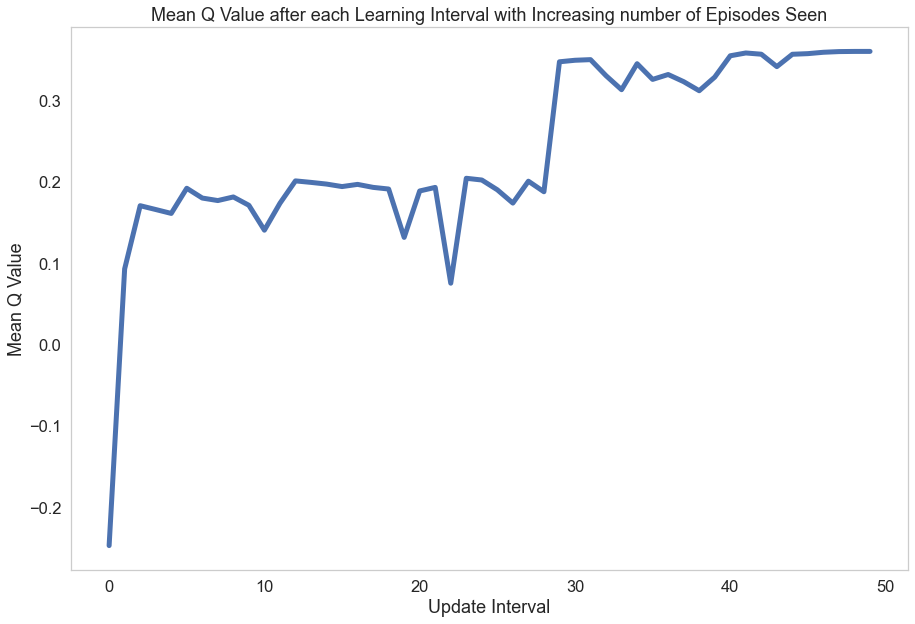

In [96]:
plt.plot(interval_value_tracker['mean_Q'])
plt.title("Mean Q Value after each Learning Interval with Increasing number of Episodes Seen")
plt.xlabel("Update Interval")
plt.ylabel("Mean Q Value")
plt.show()

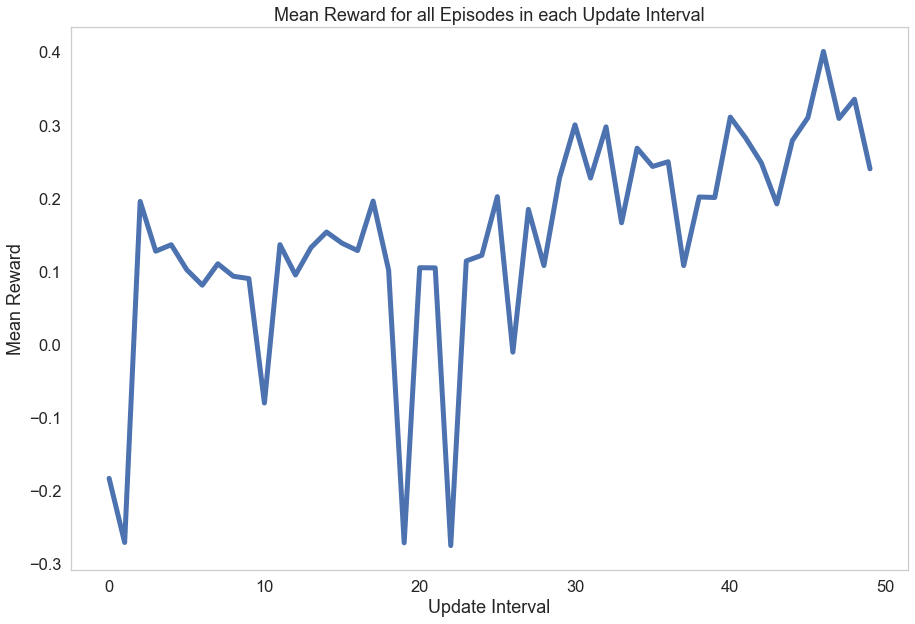

In [98]:

plt.plot(reward_tracking.groupby('interval').mean().reset_index(drop=False)['interval'],reward_tracking.groupby('interval').mean().reset_index(drop=False)['sum_R'])
plt.title("Mean Reward for all Episodes in each Update Interval")
plt.xlabel("Update Interval")
plt.ylabel("Mean Reward")
plt.show()

In [89]:
reward_tracking[reward_tracking['interval']==0]

,interval,episode,overall_episode,sum_R
0,0,0,1,1.000000
0,0,1,2,-0.712000
0,0,2,3,-0.218014
0,0,3,4,-0.205903
0,0,4,5,-1.000000
...,...,...,...,...
0,0,95,96,-0.840000
0,0,96,97,-1.000000
0,0,97,98,0.000000
0,0,98,99,-0.214412


In [90]:
states

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'M', 'recycling', 'trash']

In [91]:
policy

['left',
 'up',
 'right',
 'down',
 'down',
 'down',
 'left',
 'right',
 'right',
 'down',
 'up']

In [92]:
V_table[V_table['state']==states[0]]

,state,x,y,action,V,u,v
0,A,4,1,left,-0.546804,-1,0


In [94]:
V_table

,state,x,y,action,V,u,v
0,A,4,1,left,-0.546804,-1,0
1,B,3,1,up,-0.580693,0,1
2,C,2,1,right,-0.462096,1,0
3,D,1,1,down,-0.268928,0,0
4,E,1,2,down,-0.248168,0,-1
5,F,1,3,down,-0.223018,0,-1
6,G,2,3,left,-0.107843,-1,0
7,M,3,2,right,-0.738205,1,0
8,T,3,3,right,1.000000,1,0
